# Signal Processing

Finally we're working with real data now. In this laboratory notebook, we're working with a noisy gravitational wave dataset where we'll demonstrate Fast Fourier Transform (FFT), suppression of noise by whitening of data (that is, "uniformizing" the data), and then transform back to time domain via Inverse Fast Fourier Transform.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
from scipy import signal
from scipy.signal import windows

A bit of a segue, this is an example of how to listen to the wave. We used a random signal as an example. Note that we're not working with this.

In [2]:
duration = 5  # seconds
rate = 22050  # sampling rate in Hz
t = np.linspace(0., duration, int(rate * duration))

## What makes 440Hz interesting? See:
## * https://en.wikipedia.org/wiki/A440_(pitch_standard)
## * https://www.youtube.com/watch?v=bdih8IPQjqE
# frequency = 440
# signal = np.sin(2. * np.pi * frequency * t)

## How about white noise
signal = 0.1*np.random.normal(size=t.shape)

# Call the function to generate audio playback
display.Audio(signal, rate=rate)

Now, we're working with the real data.

### Loading the Data

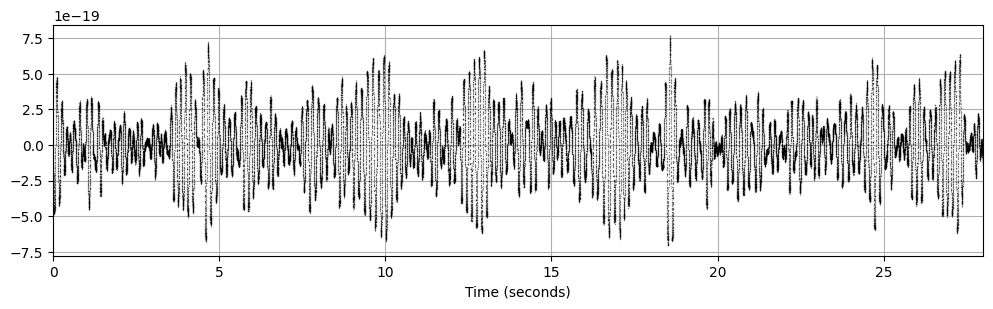

In [3]:
raw_gw = np.load("strain.npy") # Our gravitational wave data
dt = 0.000244140625 # seconds, 1/f_s, where f_s = 2**12
t = np.arange(len(raw_gw))*dt


fig, ax = plt.subplots(figsize=(12, 3), dpi=100)

ax.plot(t, raw_gw, "k+", markersize=0.1)
ax.set(xlim=[min(t), max(t)], xlabel="Time (seconds)")
ax.grid(True)


However, it is naive to say that this purely came from black hole collisions millions of light years away. We still have to remove seismic signals and other noise. For this, we use windowing (there are data points which we assume to have nothing relevant), whitening (noise uniformity), band pass filtering (to remove seismic signals which are of lower frequencies), and finally, we find the weights of each frequency on the signal.

## Tukey Windowing
For here, we'll use Tukey windowing to avoid the reduction of the frequency resolution otherwise posed by Welch averaging

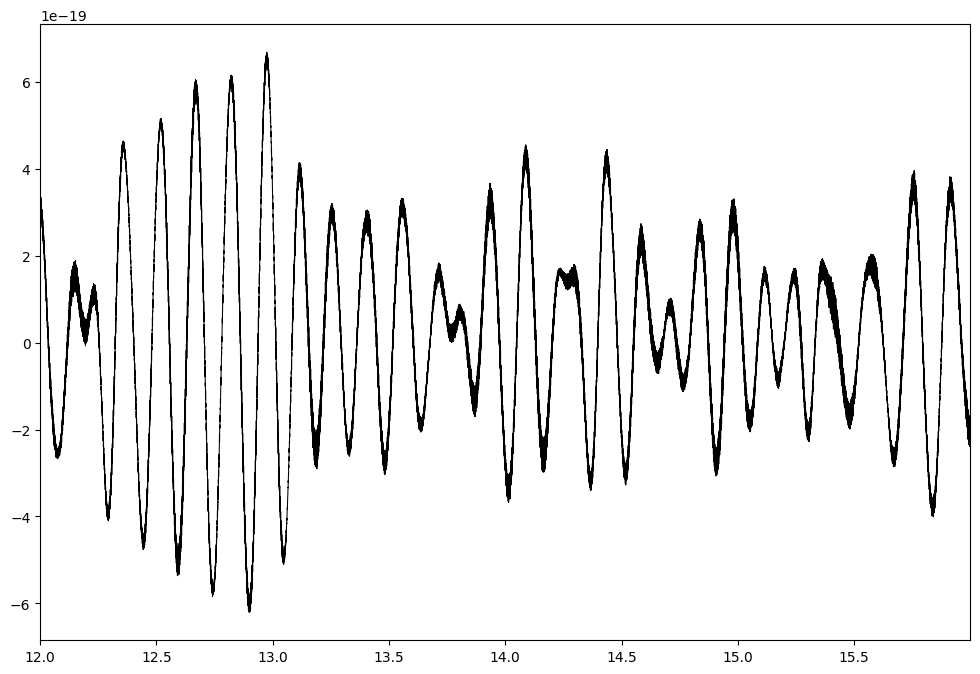

In [123]:
# Defining the window parameters in time domain
start_time = 12.0 # where we suppose the signal has started
win_size = 4.0 # seconds
win_cnt = int(win_size/dt)
start_idx = int(start_time/dt)

# Do Tukey Windowing to filter out leakage across frequencies
raw_gw_win = windows.tukey(win_cnt) 

raw_gw_sel = raw_gw[start_idx:start_idx+win_cnt]
t_sel = t[start_idx:start_idx+win_cnt]

# fig, axs = plt.subplots(3, 1, figsize=(12, 8))

plt.figure(figsize=(12, 8))
plt.plot(t_sel, raw_gw_sel, "k-", linewidth=0.75)
plt.xlim(min(t_sel), max(t_sel))


raw_gw_ft = np.fft.rfft(raw_gw_sel*raw_gw_win)
raw_gw_freq = np.fft.rfftfreq(win_cnt, d=dt)

# FIRST CANDIDATE

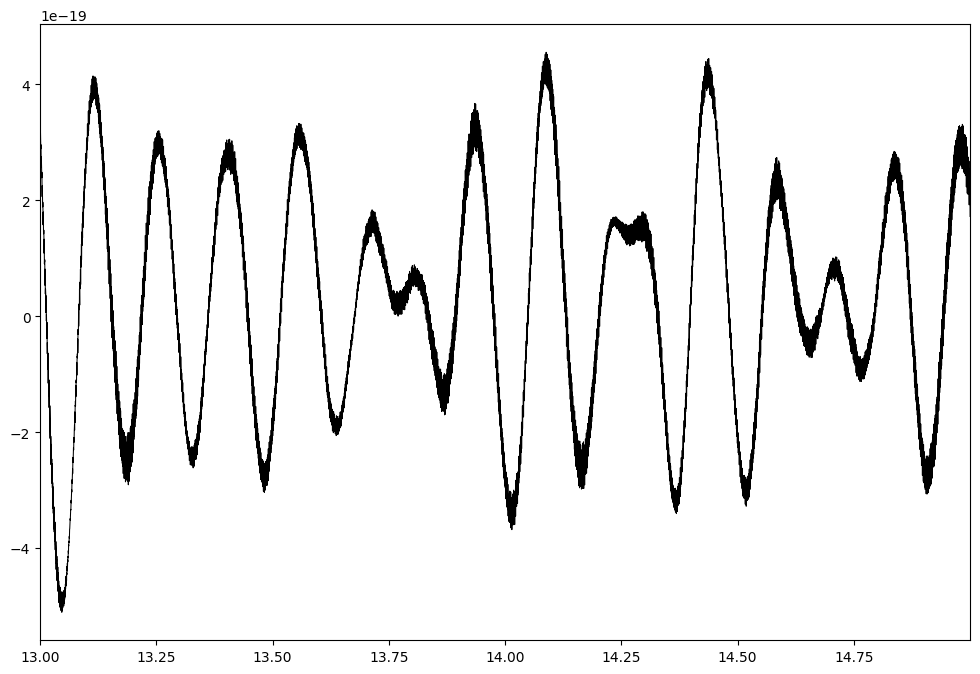

In [61]:
# # SECOND CANDIDATE
# # Defining the window parameters in time domain
# start_time = 13.0 # where we suppose the signal has started
# win_size = 2.0 # seconds
# win_cnt = int(win_size/dt)
# start_idx = int(start_time/dt)

# # Do Tukey Windowing to filter out leakage across frequencies
# raw_gw_win = windows.tukey(win_cnt) 

# raw_gw_sel = raw_gw[start_idx:start_idx+win_cnt]
# t_sel = t[start_idx:start_idx+win_cnt]

# # fig, axs = plt.subplots(3, 1, figsize=(12, 8))

# plt.figure(figsize=(12, 8))
# plt.plot(t_sel, raw_gw_sel, "k-", linewidth=0.75)
# plt.xlim(min(t_sel), max(t_sel))


# raw_gw_ft = np.fft.rfft(raw_gw_sel*raw_gw_win)
# raw_gw_freq = np.fft.rfftfreq(win_cnt, d=dt)


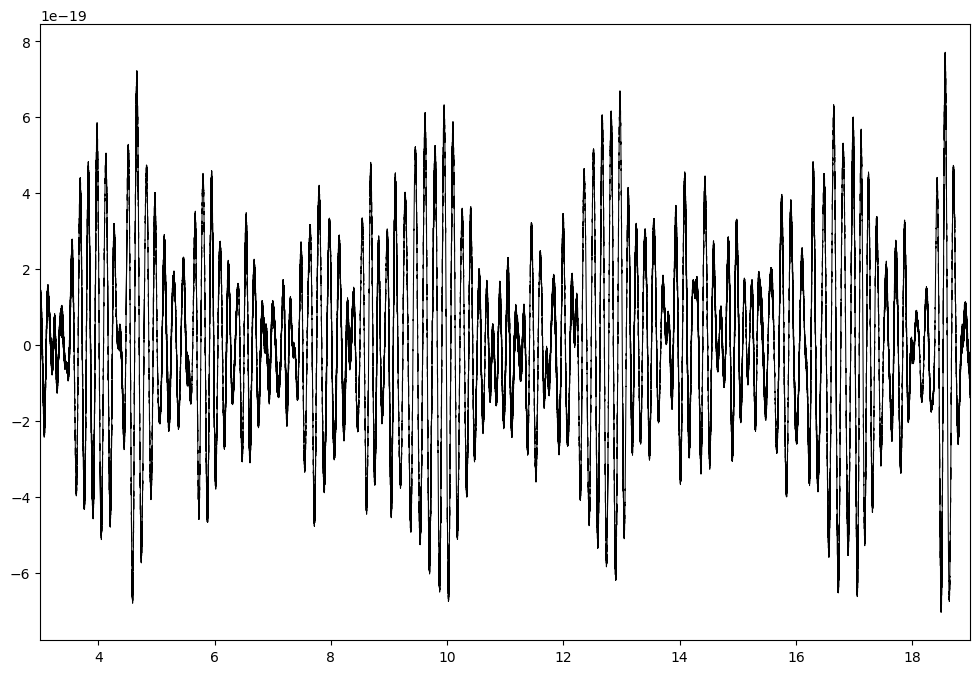

In [65]:
# # THIRD CANDIDATE
# # Defining the window parameters in time domain
# start_time = 3.0 # where we suppose the signal has started
# win_size = 16.0 # seconds
# win_cnt = int(win_size/dt)
# start_idx = int(start_time/dt)

# # Do Tukey Windowing to filter out leakage across frequencies
# raw_gw_win = windows.tukey(win_cnt) 

# raw_gw_sel = raw_gw[start_idx:start_idx+win_cnt]
# t_sel = t[start_idx:start_idx+win_cnt]

# # fig, axs = plt.subplots(3, 1, figsize=(12, 8))

# plt.figure(figsize=(12, 8))
# plt.plot(t_sel, raw_gw_sel, "k-", linewidth=0.75)
# plt.xlim(min(t_sel), max(t_sel))


# raw_gw_ft = np.fft.rfft(raw_gw_sel*raw_gw_win)
# raw_gw_freq = np.fft.rfftfreq(win_cnt, d=dt)

## Whitening
After, defining the snapshot where we're interested at, we "whiten" it so that the frequency dependence of the amplitude is removed.

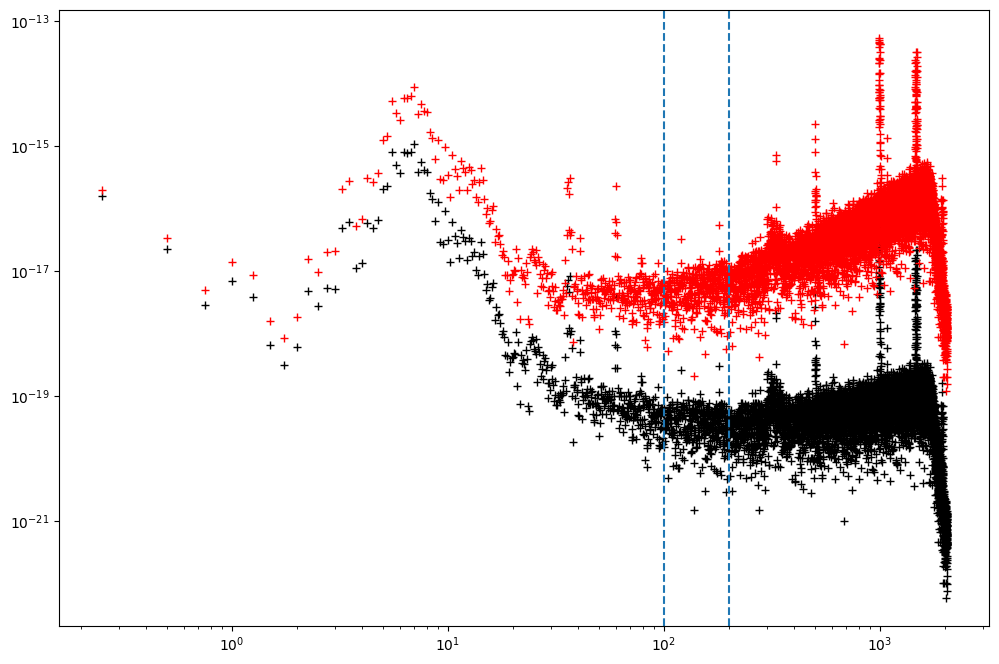

In [136]:
## THIS NOTEBOOK'S SECTION START HERE
# Illustrate whitening by multiplying with the FT with f. Try
# plotting on a separate log-log plot first to see that the original
# signal is indeed 1/f-like and that it can be "whitened"
plt.figure(figsize=(12, 8))
plt.plot(raw_gw_freq, np.abs(raw_gw_ft), "k+")
plt.plot(raw_gw_freq, np.abs(raw_gw_ft/(1/(1+raw_gw_freq))), "r+")
# plt.set_xscale(xscale="log", yscale="log")
plt.xscale("log")
plt.yscale("log")
plt.axvline(100, linestyle="--")
plt.axvline(200, linestyle="--")

## Bandpass Filter
Now, we filter out frequencies where other waves (seismic waves) reside and retain only where the magic chirp could be heard.

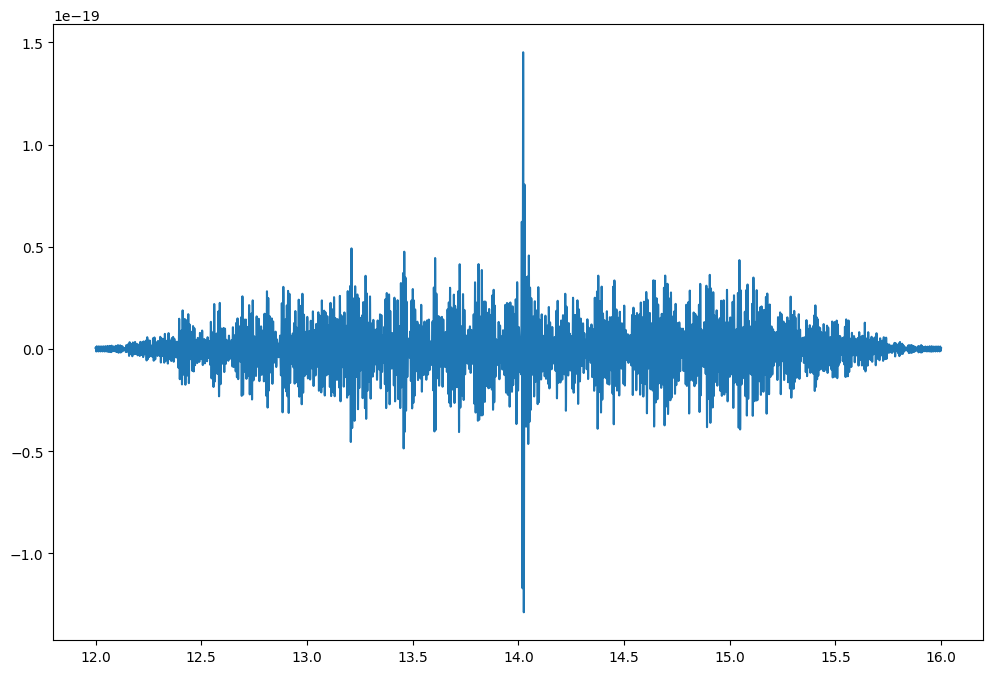

In [137]:
# Equation for whitened data
whitened = raw_gw_ft/(1/(1+raw_gw_freq))

# Bandpass Mask
# arXiv:1908.11170 suggests to filter data outside of [35 Hz, 350 Hz]
bandpass_mask_1 = 1.0*(raw_gw_freq > 100)*(raw_gw_freq < 200)# Modify to 305 Hz
bandpass_mask_2 = 1.0*(raw_gw_freq > 100)*(raw_gw_freq < 250)
# whitened bandpassed signal
chirp_host_1 = whitened*bandpass_mask_1
chirp_host_2 = whitened*bandpass_mask_2
# Transform the data back to time domain
invwhite1 = np.fft.irfft(chirp_host_1)
# invwhite2 = np.fft.irfft(chirp_host_2)

plt.figure(figsize=(12, 8))
plt.plot(t_sel, invwhite1)
# plt.plot(t_sel, invwhite2)
# plt.legend()

In [138]:
# Hear the Signal
display.Audio(chirp_host_1, rate=1/dt)

In [139]:
display.Audio(invwhite1, rate=1/dt)